# Image Colorization Using Deep Learning

# Set-Up

In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import *

tf.random.set_seed(42) 
np.random.seed(42)

# Data Preparation

## Key Variables

In [0]:
IMG_SIZE     = [224, 224]
N_CHANNELS   = 3
N_CLASSES    = 338
DATA_DIR     = "/content/drive/My Drive/sample_10/"

## Loading Data

In [0]:
x_train = np.load(file=DATA_DIR+"x_train.npy", allow_pickle=True)
y_train = np.load(file= DATA_DIR+"y_train.npy", allow_pickle=True)

x_test = np.load(file=DATA_DIR+"x_test.npy", allow_pickle=True)
y_test = np.load(file=DATA_DIR+"y_test.npy", allow_pickle=True)

y_train = tf.keras.utils.to_categorical(y=y_train, num_classes=N_CLASSES)
y_test = tf.keras.utils.to_categorical(y=y_test, num_classes=N_CLASSES)

# Model Architecture

## Model Building

In [0]:
def FCN8(image_size, ch_in, ch_out):
  
    inputs = Input(shape=(*image_size, ch_in), name='input')

    # Building a pre-trained VGG-16 as a feature extractor, without the final FC layers
    vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=inputs)

    # Feature maps of final 3 blocks:
    f3 = vgg16.get_layer('block3_pool').output  # shape: (28, 28, 256)
    f4 = vgg16.get_layer('block4_pool').output  # shape: (14, 14, 512)
    f5 = vgg16.get_layer('block5_pool').output  # shape: ( 7,  7, 512)

    f5conv1 = Conv2D(filters=4086, kernel_size=7, padding='same', activation='relu')(f5)
    f5drop1 = Dropout(0.5)(f5conv1)
    f5conv2 = Conv2D(filters=4086, kernel_size=1, padding='same', activation='relu')(f5drop1)
    f5drop2 = Dropout(0.5)(f5conv2)
    f5conv3 = Conv2D(filters=ch_out, kernel_size=1, padding='same', activation=None)(f5drop2)

    # Upscale f5 into a 14x14 feature map
    f5conv3x2 = Conv2DTranspose(filters=ch_out, kernel_size=4, strides=2, use_bias=False, padding='same', activation='relu')(f5)
    f4conv1 = Conv2D(filters=ch_out, kernel_size=1, padding='same', activation=None)(f4)
    m1 = add([f4conv1, f5conv3x2])

    m1x2 = Conv2DTranspose(filters=ch_out, kernel_size=4, strides=2, use_bias=False, padding='same', activation='relu')(m1)
    f3conv1 = Conv2D(filters=ch_out, kernel_size=1, padding='same', activation=None)(f3)
    m2 = add([f3conv1, m1x2])

    # Upscale the feature map to the original shape of 224x224
    outputs = Conv2DTranspose(filters=ch_out, kernel_size=16, strides=8, padding='same', activation='softmax')(m2)
    
    model = Model(inputs, outputs)
    return model

## Model Instantiation and summary

In [5]:
model = FCN8(IMG_SIZE, N_CHANNELS, N_CLASSES)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input[0][0]                      
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
______________________________________________________________________________________________

# Training Preparation 

## Metrics and Loss

**Metrices:** Accuracy and IoU


**Loss:** cross-entropy vs. Dice

In [0]:
accuracy = tf.metrics.Accuracy(name='acc')
meanIoU  = tf.metrics.MeanIoU(num_classes=N_CLASSES, name='mIoU')
loss_c = tf.keras.losses.CategoricalCrossentropy()

Since we are doing multi-class classification task (pixel-level classification), we can use **cross-entropy loss**. However, to prevent the model from developing bias towards larger classes, **dice loss function** will be used because it is not affected by class proportions.

In [0]:
# TODO: Dice loss

## Optimizer and Callbacks

In [0]:
optimizer = tf.keras.optimizers.Adam()

## Hyper Parameters

In [0]:
BATCH_SIZE     = 8
NUM_EPOCHS     = 5

## Helper Functions

# Training

In [14]:
model.compile(optimizer=optimizer, loss=loss_c, metrics=[accuracy, meanIoU])
history = model.fit(x=x_train, y=y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_split=0.1765)

Epoch 1/5
1/1 [==============================] - 1s 965ms/step - loss: 10.8959 - acc: 0.9937 - mIoU: 0.5880 - val_loss: 10.1361 - val_acc: 0.9963 - val_mIoU: 0.6120
Epoch 2/5
1/1 [==============================] - 0s 491ms/step - loss: 10.8039 - acc: 0.9960 - mIoU: 0.5967 - val_loss: 10.0907 - val_acc: 0.9963 - val_mIoU: 0.6131
Epoch 3/5
1/1 [==============================] - 0s 497ms/step - loss: 10.7674 - acc: 0.9960 - mIoU: 0.5975 - val_loss: 10.1167 - val_acc: 0.9963 - val_mIoU: 0.6126
Epoch 4/5
1/1 [==============================] - 0s 482ms/step - loss: 10.9149 - acc: 0.9960 - mIoU: 0.5942 - val_loss: 9.8915 - val_acc: 0.9964 - val_mIoU: 0.6179
Epoch 5/5
1/1 [==============================] - 0s 483ms/step - loss: 10.6793 - acc: 0.9961 - mIoU: 0.5995 - val_loss: 9.8158 - val_acc: 0.9964 - val_mIoU: 0.6197


## Graphs

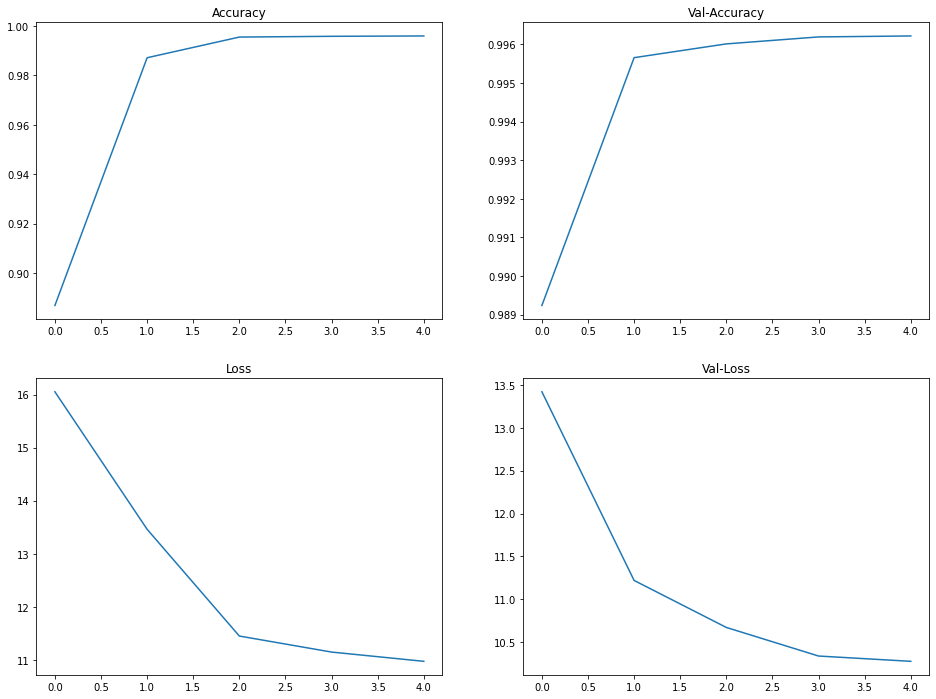

In [12]:
# Plot accuracy and loss plots

fig, ax = plt.subplots(2, 2, figsize=(16, 12))
ax[0, 0].set_title("Accuracy")
ax[0, 1].set_title("Val-Accuracy")
ax[1, 0].set_title("Loss")
ax[1, 1].set_title("Val-Loss")

ax[0, 0].plot(history.history['acc'])
ax[0, 1].plot(history.history['val_acc'])
ax[1, 0].plot(history.history['loss'])
ax[1, 1].plot(history.history['val_loss'])

# Testing

In [13]:
history_test = model.evaluate(x=x_test, y=y_test)

1/1 [==============================] - 0s 1ms/step - loss: 12.0619 - acc: 0.9867 - mIoU: 0.5689


# Prediction

In [0]:
# Predict label map 
# label_map = np.argmax(fcn8s_model.predict(image), axis=-1)

# Note:  maybe save the model after training and load for prediction? See Exam 1 for reference

# Post-process Image

In [0]:
gpu = tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

print(gpu)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True
